<a href="https://colab.research.google.com/github/CodingDuckmx/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Jesus_CaballeroMedrano_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [262]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [264]:
df.head()
df['Burrito'].unique()

array(['California ', 'Carnitas', 'Carne asada', 'California',
       'combo chicken', 'Monster California', 'Carne Asada',
       'Surf & Turf', 'Chile verde pork', 'battered fish ',
       'Surf and turf ', 'Adobada ', 'Barbacoa', '2 in 1', 'Adobado',
       'Shredded beef', 'Hawaiian', 'Bandido', 'Campeon', 'carne asada',
       'California chicken', 'Azteca', 'Lobster', 'Al pastor', 'Custom',
       'Machaca', 'Quesaburro', 'Philly ', 'Quesa', 'Surf and turf',
       'Mahi', 'Addiction', 'Oaxacalifornia', "Deborah's special",
       'Chicken nopalito', 'Adobada', 'Chicken', 'California Everything',
       'Chile relleno and carnitas', 'California (only cheese)', 'Fish',
       'Chimichanga beef', 'Pastor', 'El Hawaiiano ', 'Shrimp',
       'El Rusio', 'Bacon breakfast', 'Chile Relleno', 'Bomb', 'Arizona',
       'California Burrito', '619 Burrito Original', 'Chicken asada',
       'Carne adobada ', 'Bean and cheese', 'Pokirrito classic ',
       'Mauna Lani', 'Especial ', 'Ranchero

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [266]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Oscar's Mexican food,Asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

#My Work

###import libraries

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import category_encoders as ce

##Basic Data Analysis

In [270]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [271]:
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [272]:
df.isnull().sum() / len(df) * 100

Burrito             0.000000
Date                0.000000
Yelp               79.334917
Google             79.334917
Chips              93.824228
Cost                1.662708
Hunger              0.712589
Mass (g)           94.774347
Density (g/mL)     94.774347
Length             32.779097
Circum             33.254157
Volume             33.254157
Tortilla            0.000000
Temp                4.750594
Meat                3.325416
Fillings            0.712589
Meat:filling        2.137767
Uniformity          0.475059
Salsa               5.938242
Synergy             0.475059
Wrap                0.712589
Unreliable         92.161520
NonSD              98.337292
Beef               57.482185
Pico               62.470309
Guac               63.420428
Cheese             62.232779
Fries              69.833729
Sour cream         78.147268
Pork               87.885986
Chicken            95.011876
Shrimp             95.011876
Fish               98.574822
Rice               91.448931
Beans         

In [273]:
#I'm taking just the columns having no more than 5% of null values, so my dataset would be:

(df.isnull().sum() / len(df) < 0.05)[(df.isnull().sum() / len(df) < 0.05) == True].index
df05 = df[(df.isnull().sum() / len(df) < 0.05)[(df.isnull().sum() / len(df) < 0.05) == True].index]

display(df05.shape)
df05.head()

(421, 13)

,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Synergy,Wrap,Great
0,California,2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,False
1,California,2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,2.5,5.0,False
2,Carnitas,2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,5.0,False
3,Asada,2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,5.0,False
4,California,2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,4.5,4.0,True


In [274]:
train = df05[df05['Date']< "2017-01-1"]
validate = df05[(df05['Date']>= "2017-01-1") & (df['Date']< "2018-01-1")]
test = df05[df05['Date']>= "2018-01-1"]


display(train)
print('\n')
display(validate)
print('\n')
display(test)

,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Synergy,Wrap,Great
0,California,2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,False
1,California,2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,2.5,5.0,False
2,Carnitas,2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,5.0,False
3,Asada,2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,5.0,False
4,California,2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,4.5,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,California,2016-12-02,5.65,3.0,4.0,1.5,2.0,3.0,4.2,4.0,2.0,4.5,False
297,Other,2016-12-02,5.49,3.0,4.5,5.0,2.0,2.0,2.5,3.5,2.5,3.0,False
298,California,2016-12-10,7.75,4.0,3.5,2.5,3.0,3.3,1.4,2.3,3.3,4.5,False
299,Asada,2016-12-10,7.75,4.0,4.0,4.5,2.0,2.0,3.5,3.5,2.0,4.0,False


,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Synergy,Wrap,Great
301,California,2017-01-04,6.60,NaN,4.0,4.5,4.0,3.5,3.5,5.0,3.50,4.5,False
302,Other,2017-01-04,6.60,NaN,4.0,2.0,NaN,4.0,NaN,4.6,3.75,5.0,False
303,Other,2017-01-07,8.50,3.9,3.0,4.5,4.1,3.0,3.7,4.0,4.20,5.0,False
304,Other,2017-01-07,7.90,4.0,3.5,4.0,4.0,3.0,4.0,4.5,3.80,4.8,False
305,Other,2017-01-10,4.99,3.5,2.5,4.5,3.0,2.5,3.0,3.0,2.00,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,California,2017-09-05,6.85,3.5,3.0,4.5,3.8,3.8,4.0,3.5,4.00,3.0,True
382,California,2017-09-05,6.85,3.5,3.0,4.5,4.0,4.0,4.5,3.0,4.00,3.5,True
383,Other,2017-12-16,11.50,3.5,2.0,2.0,4.0,3.5,3.0,4.5,4.00,2.0,False
384,California,2017-12-29,7.89,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.30,4.5,True


,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Synergy,Wrap,Great
77,California,2026-04-25,8.00,4.0,4.5,5.0,5.0,5.0,4.5,5.0,5.0,5.0,True
386,California,2018-01-02,7.25,4.0,4.0,5.0,4.0,5.0,5.0,3.0,4.0,5.0,False
387,Other,2018-01-09,4.19,3.0,3.0,5.0,2.0,2.0,4.0,1.0,3.0,4.0,False
388,California,2018-01-12,7.00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,True
389,Other,2018-01-12,8.50,4.0,4.0,4.0,3.0,3.5,1.0,2.0,3.0,1.0,False
390,Asada,2018-04-04,7.20,3.0,4.0,5.0,4.0,3.0,3.0,3.0,3.0,4.0,True
391,Carnitas,2018-04-09,5.99,3.0,3.5,5.0,4.3,3.5,5.0,4.0,3.8,2.0,True
392,Carnitas,2018-04-09,5.99,3.5,4.0,4.5,5.0,4.5,5.0,4.0,4.5,4.0,True
393,Carnitas,2018-04-09,5.99,2.0,2.0,3.5,4.5,4.0,4.0,2.0,4.0,2.0,False
394,California,2018-04-14,8.99,4.0,4.5,4.5,4.0,4.0,3.0,4.0,4.0,3.0,True


## Begin with baselines for classification.

In [275]:
##Determine the majority class

target = 'Great'
y_train = train[target]
y_val = validate[target]
y_test = test[target]

y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [276]:
### I'm choosing False as the majority class

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

print(f'The class baseline accuracy is {accuracy_score(y_train,y_pred):.4f}')

The class baseline accuracy is 0.5906


In [277]:

y_validate = validate[target]
majority_class = y_validate.mode()[0]
y_pred = [majority_class] * len(y_validate)

print(f'The class baseline accuracy is {accuracy_score(y_validate,y_pred):.4f}')

The class baseline accuracy is 0.5529


## Use scikit-learn for logistic regression.

In [0]:
## Arrange X feature matrices

features = df05.columns.drop(['Date','Great'])

X_train = train[features]
X_val = validate[features]
X_test = test[features]

In [279]:
## instantiate and fir / transform the Burrito column

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_test_enc = encoder.transform(X_test)

display(X_train_enc.head())
X_val_enc.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Synergy,Wrap
0,1,0,0,0,0,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0
1,1,0,0,0,0,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,2.5,5.0
2,0,1,0,0,0,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,5.0
3,0,0,1,0,0,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,5.0
4,1,0,0,0,0,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,4.5,4.0


,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Synergy,Wrap
301,1,0,0,0,0,6.60,NaN,4.0,4.5,4.0,3.5,3.5,5.0,3.50,4.5
302,0,0,0,1,0,6.60,NaN,4.0,2.0,NaN,4.0,NaN,4.6,3.75,5.0
303,0,0,0,1,0,8.50,3.9,3.0,4.5,4.1,3.0,3.7,4.0,4.20,5.0
304,0,0,0,1,0,7.90,4.0,3.5,4.0,4.0,3.0,4.0,4.5,3.80,4.8
305,0,0,0,1,0,4.99,3.5,2.5,4.5,3.0,2.5,3.0,3.0,2.00,4.0


In [0]:
## Impute missing values

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_enc)
X_val_imputed = imputer.transform(X_val_enc)
X_test_imputed = imputer.transform(X_test_enc)

In [281]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train_imputed,y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed,y_val))

Validation Accuracy 0.8470588235294118


In [282]:
### Second chance

## I tried out with some more flexibility on the null values, but I have to admit 33% of null values to have 15 columns. I'm not quite confident with that.

for n in range(1,8,1):
  
  m = 0.05*n
  dfn = df[(df.isnull().sum() / len(df) < m)[(df.isnull().sum() / len(df) < m) == True].index]
  display(f'Number of columns with less than {m*100:.0f}% of null values: {dfn.shape[1]}')

# display(df10.head())

print('\n')
display(f'Number of columns with less than {33}% of null values: {df[(df.isnull().sum() / len(df) < .33)[(df.isnull().sum() / len(df) < .33) == True].index].shape[1]}')


'Number of columns with less than 5% of null values: 13'

'Number of columns with less than 10% of null values: 14'

'Number of columns with less than 15% of null values: 14'

'Number of columns with less than 20% of null values: 14'

'Number of columns with less than 25% of null values: 14'

'Number of columns with less than 30% of null values: 14'

'Number of columns with less than 35% of null values: 17'

'Number of columns with less than 33% of null values: 15'

In [283]:
# The columns I'll consider now are:

df33 = df[(df.isnull().sum() / len(df) < 0.33)[(df.isnull().sum() / len(df) < 0.33) == True].index]

display(df33.shape)
display(df33.head())
print('\n')
display('The new column to consider is Length.')

(421, 15)

,Burrito,Date,Cost,Hunger,Length,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,2016-01-18,6.49,3.0,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,2016-01-24,5.45,3.5,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,2016-01-24,4.85,1.5,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,2016-01-24,5.25,2.0,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,2016-01-27,6.59,4.0,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


'The new column to consider is Length.'

In [284]:
### So I'll divide it into train, validate and test subsets.

train15 = df33[df33['Date'] < '2017-1-1']
validate15 = df33[(df33['Date'] >= '2017-1-1') & (df33['Date'] < '2018-1-1') ]

display(train15.shape)
display(validate15.shape)



(298, 15)

(85, 15)

In [0]:
##Arange the X matrices.

features15 = df33.columns.drop(['Date', 'Great'])


X_train15 = train15[features15]
X_val15 = validate15[features15]



In [0]:
### Divide the Burrito column

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded15 = encoder.fit_transform(X_train15)
X_val_encoded15 = encoder.transform(X_val15)

In [0]:
###
imputer = SimpleImputer(strategy='mean')
X_train_imputed15 = imputer.fit_transform(X_train_encoded15)
X_val_imputed15 = imputer.transform(X_val_encoded15)

In [288]:
log_reg15 = LogisticRegression(solver='liblinear')
log_reg15.fit(X_train_imputed15,y_train)
print('Validation Accuracy:', log_reg15.score(X_val_imputed15,y_val))

Validation Accuracy: 0.7411764705882353


### Get your model's test accuracy.

I'm going with the first model, because it has a bigger accuracy.

In [230]:
print('Validation accuracy for the test:', log_reg.score(X_test_imputed,y_test))

Validation accuracy for the test: 0.7894736842105263


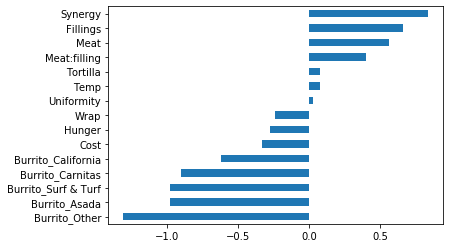

In [293]:
# %matplotlib
coefficients = pd.Series(log_reg.coef_[0],X_train_enc.columns)
coefficients.sort_values().plot.barh();


##Share of Grat Burritos


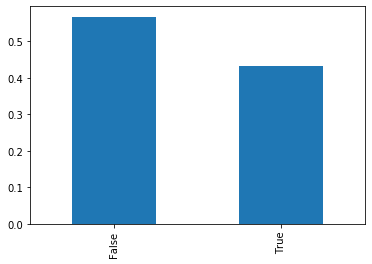

In [256]:
%matplotlib inline

# df['Great'].count_values().plot.barh()


df['Great'].value_counts(normalize=True).plot(kind='bar')

##Draft

In [221]:
len(df.columns)

59

In [222]:
m = 0.33

(df.isnull().sum() / len(df) < m)[(df.isnull().sum() / len(df) < majority_class) == True].index
df[(df.isnull().sum() / len(df) < m)[(df.isnull().sum() / len(df) < m) == True].index].shape

(421, 15)

In [223]:
X_train.dtypes

Burrito          object
Cost            float64
Hunger          float64
Tortilla        float64
Temp            float64
Meat            float64
Fillings        float64
Meat:filling    float64
Uniformity      float64
Synergy         float64
Wrap            float64
dtype: object